# Inaugural Project

Imports and set magics:

In [105]:
import numpy as np
import matplotlib.pylab as plt
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import inauguralproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

BRIEFLY EXPLAIN HOW YOU SOLVE THE MODEL.

In [84]:
# code for solving the model (remember documentation and comments) This is fine
# Using condition (2) on equation(1) we define the utility function of the consumer:
def utility(w, l, m = 1, v = 10, epsilon = 0.3, tau0 = 0.4, tau1 = 0.1, kappa = 0.4):
    tax = tau0*w*l+tau1*np.fmax(w*l-kappa,0)
    c = m+w*l-tax
    utility = np.log(c)-v*l**(1+1/epsilon)/(1+1/epsilon)
    return utility,c, tax

In [158]:
# Then we create a function to maximize the utility for given parameters:
def solveconsumerproblem(w, m = 1, v = 10, epsilon = 0.3, tau0 = 0.4, tau1 = 0.1, kappa = 0.4, N=200,
                         callableoutput=False, tax=False):

    "Solves the consumerproblem for given parameters. If callableoutput is True the output is a tuple   with callable values, else the output is a neatly formatted string. If Tax is true, the consumers tax payment will be included in the output."

# We start by creating empty lists to store the output in.
    c_star = [0]
    l_star = [0]
    t_star = [0]
    utility_star = [-np.inf]
    
    Range = np.linspace(0, 1, N)
    for i in Range:
        utility_temp = utility(l = i, w = w, epsilon = epsilon)
        if utility_temp[0]>utility_star:
            utility_star[0]=utility_temp[0]
            l_star[0] = i
            c_star[0] = utility_temp[1]
            t_star[0] = utility_temp[2]

    if tax == False:
        if callableoutput == False:
            print(f"The optimal labour and consumption (l*,C*) = ({l_star[0]:.3}, {c_star[0]:.3}) -> u(C*,l*) = {c_star[0]:.3}")  
        else:
            return utility_star[0], l_star[0], c_star[0]
    
    if tax == True:
            return utility_star[0], l_star[0], c_star[0], t_star[0]

In [159]:
solveconsumerproblem(w=1.33, tax=True, callableoutput=True)

(0.22360054677819302,
 0.40703517587939697,
 1.310678391959799,
 0.23067839195979897)

# Question 2

ADD ANSWER.

In [160]:
# We start by generating lists of $l^*$ and $c^*$, containing the optimal values of l and c, for a given w.

w_range = np.linspace(0.5, 1.5, 200) # We define a range of w

# We create the empty lists for the output
l_list = []
c_list = []

# Then we loop through the w_range and save the optimal values of c and l
for i in w_range:
    l_list.append(solveconsumerproblem(w = i, callableoutput=True)[1])
    c_list.append(solveconsumerproblem(w = i, callableoutput=True)[2])

Text(0, 0.5, 'forbrug')

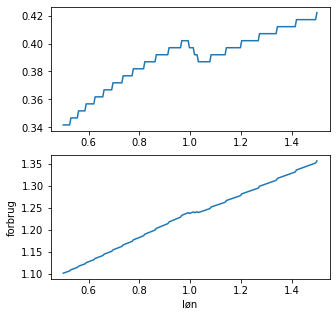

In [161]:
fig = plt.figure(figsize=(5,5))

# WAKE ME UP, WAKE ME UP INSIDE - CANT WAKE UP
# sub figure 1
ax.plot = fig.add_subplot(2,1,1)
plt.plot(w_range,l_list)
ax.set_ylabel("arbejde")

# sub figure 2
ax = fig.add_subplot(2,1,2)
ax.plot(w_range, c_list)
ax.set_xlabel('løn')
ax.set_ylabel('forbrug')

# Question 3

ADD ANSWER.

In [155]:
# We start by generating the different wages for the different consumers
wage_list = np.random.uniform(low = 0.5, high = 1.5, size = 10000)

# Create and empty list to store output
tax_payments = []

# Loop through the list of wages and save the tax payment, for optimal values of l and C
for i in wage_list:
    tax_payments.append(solveconsumerproblem(w = i, callableoutput = True, tax = True)[-1])

# Then we take the sum of all elements in the list, giving us the total tax revenu 
np.sum(tax_payments)


1626.8995151293732

# Question 4

ADD ANSWER.

In [162]:
# Create and empty list to store output
tax_payments = []
# Loop through the list of wages and save the tax payment, for optimal values of l and C
for i in wage_list:
    tax_payments.append(solveconsumerproblem(w = i, epsilon = 0.1, callableoutput = True, tax = True)[3])

# Then we take the sum of all elements in the list, giving us the total tax revenu 
np.sum(tax_payments)



3190.894959434346

# Question 5

ADD ANSWER.

In [6]:
# code

# Conclusion

ADD CONCISE CONLUSION.